
# Lab 2: Sentiment Analysis with a Multi Layer Perceptron using Keras

__Objective__: We'll repeat the experiments in Lab 1, but in this case we'll extend the model adding new layers. In addition we will review some of the regularization techniques seen in class. The objectives for the lab session are the following:

- Learn adding layers in Keras.
- Experiment using different number of hidden layers with different hidden units.
- Experiment with regularization techniques such as early-stoping, reducing the model, weight regularization and drop-out.


## 1. Loading the data
We'll use the same data used in previous session. You need to follow the same steps specified in lab1.

In [ ]:
# Mount Drive files
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
## for replicability of results
import numpy as np
import tensorflow as tf

np.random.seed(1)
tf.random.set_seed(2)

In [ ]:
import re
import pandas as pd

# Let's do 2-way positive/negative classification instead of 5-way
def load_sst_data(path,
                  easy_label_map={0:0, 1:0, 2:None, 3:1, 4:1}):
    data = []
    with open(path) as f:
        for i, line in enumerate(f):
            example = {}
            example['label'] = easy_label_map[int(line[1])]
            if example['label'] is None:
                continue

            # Strip out the parse information and the phrase labels---we don't need those here
            text = re.sub(r'\s*(\(\d)|(\))\s*', '', line)
            example['text'] = text[1:]
            data.append(example)
    data = pd.DataFrame(data)
    return data

sst_home = '/content/drive/MyDrive/ColabNotebooksHapLab/TIA-2024-2025/data/trees/'
training_set = load_sst_data(sst_home + 'train.txt')
dev_set = load_sst_data(sst_home + 'dev.txt')
test_set = load_sst_data(sst_home + 'test.txt')

print('Training size: {}'.format(len(training_set)))
print('Dev size: {}'.format(len(dev_set)))
print('Test size: {}'.format(len(test_set)))

Training size: 6920
Dev size: 872
Test size: 1821


## 2. Preprocessing and vectorization

In [ ]:
from tensorflow.keras.preprocessing import text
from sklearn.utils import shuffle

# Shuffle dataset
training_set = shuffle(training_set)
dev_set = shuffle(dev_set)

test_set = shuffle(test_set)

# Obtain text and label vectors, and tokenize the text
train_texts = training_set.text
train_labels = training_set.label

dev_texts = dev_set.text
dev_labels = dev_set.label

test_texts = test_set.text
test_labels = test_set.label

# Create a tokenize that takes the 1000 most common words
tokenizer = text.Tokenizer(num_words=1000)

# Build the word index (dictionary)
tokenizer.fit_on_texts(train_texts) # Create word index using only training part

# Vectorize texts into one-hot encoding representations
x_train = tokenizer.texts_to_matrix(train_texts, mode='binary')
x_dev = tokenizer.texts_to_matrix(dev_texts, mode='binary')
x_test = tokenizer.texts_to_matrix(test_texts, mode='binary')

y_train = train_labels
y_dev = dev_labels
y_test = test_labels

print('Shape of the training set (nb_examples, vector_size): {}'.format(x_train.shape))
print('Shape of the validation set (nb_examples, vector_size): {}'.format(x_dev.shape))
print('Shape of the test set (nb_examples, vector_size): {}'.format(x_test.shape))

Shape of the training set (nb_examples, vector_size): (6920, 1000)
Shape of the validation set (nb_examples, vector_size): (872, 1000)
Shape of the test set (nb_examples, vector_size): (1821, 1000)


## 3. Building the model
Based on previous code we'll extend the model to a Multi Layer Perceptron with one hidden units. For that we'll make use of a fully connected (```Dense```) layers with a ```relu``` activation. In this case the hidden layer will have 16 hidden units (feel free to explore different dimensionality of hidden units).

Remenber that applying ```Dense``` layer with ```relu``` activation we are implementing the following tensor operation:

```
output = relu(dot(W, input) + b)
```
### Exercise 1
Answer the following questions:
- What does having 16 hidden units mean? What the size of matrix ```W```?

-----

Increasing the number of hidden units we are allowing the network to learn more complex representations, but at the same time we are making the network more computationally expensive and may lead to overfit the training data.

Regarding the architecture, there are three main decisions that we need to take:
- The number of layers
- The number of hidden units for each layers
- Activation function of the layers

The code below implements a fully connected archicteture with only one intermediate layer and an output layer that predicts the sentiment of the input review.

>>>>>>>![](http://ixa2.si.ehu.es/~jibloleo/uc3m_dl4nlp/img/Two_layers_NN.png)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

input_size = x_train[0].shape[0] ## vector length equals to vocabulary size.

# Define the model
model = Sequential()
model.add(Dense(units=16, activation='relu', input_shape=(input_size,)))
model.add(Dense(units=1, activation='sigmoid'))
# Note that we do not need to indicate the input shape for the sucessives layes

# Compile the model using a loss function and an optimizer.
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 16)                  │          16,016 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,033 (62.63 KB)

 Trainable params: 16,033 (62.63 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(x_train, y_train, epochs=100, batch_size=32, validation_data=(x_dev, y_dev), verbose=1)

Epoch 1/100
217/217 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5673 - loss: 0.6780 - val_accuracy: 0.7534 - val_loss: 0.5742
Epoch 2/100
217/217 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7433 - loss: 0.5530 - val_accuracy: 0.7718 - val_loss: 0.5046
Epoch 3/100
217/217 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7904 - loss: 0.4734 - val_accuracy: 0.7695 - val_loss: 0.4919
Epoch 4/100
217/217 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8067 - loss: 0.4374 - val_accuracy: 0.7649 - val_loss: 0.4940
Epoch 5/100
217/217 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8137 - loss: 0.4168 - val_accuracy: 0.7603 - val_loss: 0.5006
Epoch 6/100
217/217 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8183 - loss: 0.4028 - val_accuracy: 0.7580 - val_loss: 0.5083
Epoch 7/100
217/217 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8207 - loss: 0.3920 - val_accuracy: 0.7603 - val_loss: 0.5158
Epoch 8/100
217/217 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8235 - loss: 0.3827 - val_accu

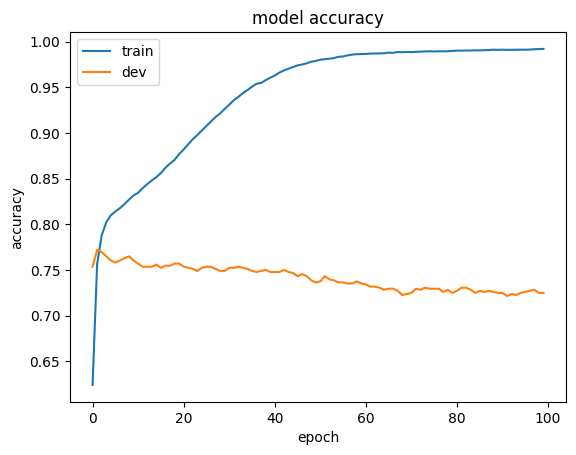

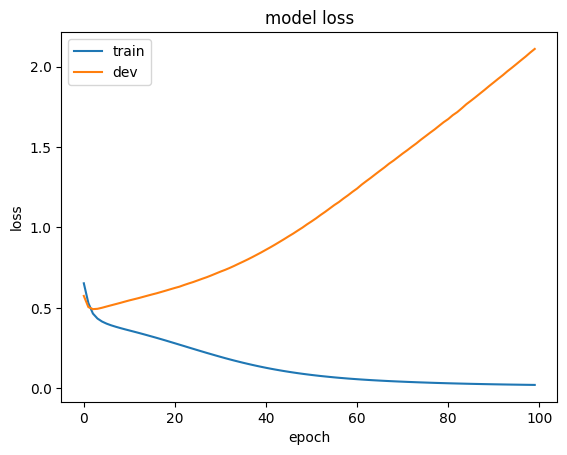

In [ ]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper left')
plt.show()


# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper left')
plt.show()

### Exercise 2
Plots shows that model ends up overfitting the training data. One way to prevent overfitting is to stop training once accuracy in the validation set starts decreasing.
- Could you retrain the model from the scratch for only four epochs?

- Optionally, Keras provides early stopping mechanism as callback object(https://keras.io/callbacks/#earlystopping) that could be used when fiting the model:

```
from tensorflow.keras.callbacks import EarlyStopping
...
early_stop = EarlyStopping(monitor='val_accuracy', patience=1)
...
history_exercise = model.fit(x_train, y_train, epochs=100, batch_size=32, validation_data=(x_dev, y_dev), verbose=1, callbacks=[early_stop])

```

In [ ]:
### TODO: copy the code above and adapt to complete the exercise
from tensorflow.keras.callbacks import EarlyStopping
model = Sequential()
model.add(Dense(units=16, activation='relu', input_shape=(input_size,)))
model.add(Dense(units=1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
early_stop = EarlyStopping(monitor='val_accuracy', patience=1)
history_exer = model.fit(x_train, y_train, epochs=100, batch_size=32, validation_data=(x_dev, y_dev), verbose=1, callbacks=[early_stop])
score = model.evaluate(x_test, y_test, verbose=1)
print("Accuracy: ", score[1])

Epoch 1/100
217/217 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5725 - loss: 0.6788 - val_accuracy: 0.7374 - val_loss: 0.5824
Epoch 2/100
217/217 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7509 - loss: 0.5564 - val_accuracy: 0.7592 - val_loss: 0.5080
Epoch 3/100
217/217 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7884 - loss: 0.4747 - val_accuracy: 0.7683 - val_loss: 0.4935
Epoch 4/100
217/217 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8081 - loss: 0.4374 - val_accuracy: 0.7683 - val_loss: 0.4953
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7476 - loss: 0.5011
Accuracy:  0.7594727873802185


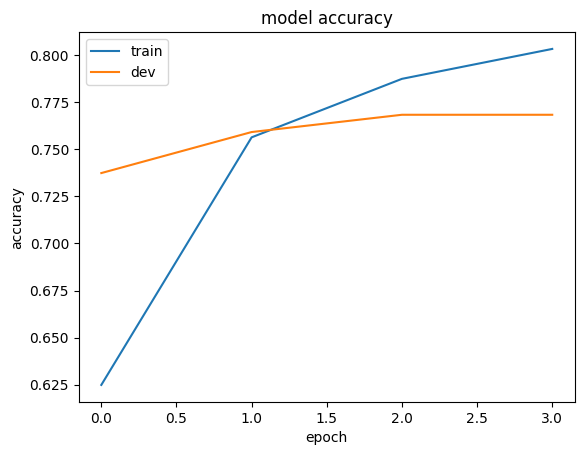

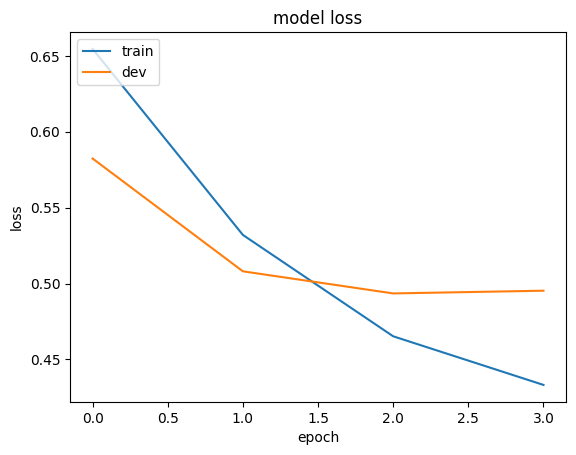

In [ ]:
# summarize history for accuracy
plt.plot(history_exer.history['accuracy'])
plt.plot(history_exer.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper left')
plt.show()


# summarize history for loss
plt.plot(history_exer.history['loss'])
plt.plot(history_exer.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper left')
plt.show()

---
- Optionally you can try different activations (e.g ```tanh```, ```sigmoid```) instead of ```relu```.
- Or try different loss function like mean_squared_error (```mse```).

---

## 3.1 Adding new layers
In this section we will extend the model by adding new fully connected layer. By adding new layers we are increasing the capacity of the model we are not reducing the overfitting, but for the moment  we do not care about this.

### Exercise 3
- The code below defines a model with two hidden layers,  add a third intermediate layer with 16 hidden units and ```relu``` activation.

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                      │ (None, 16)                  │          16,016 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 16)                  │             272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,305 (63.69 KB)

 Trainable params: 16,305 (63.69 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
217/217 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5453 - loss: 0.6800 - val_accuracy: 0.7420 - val_loss: 0.5675
Epoch 2/20
217/217 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7464 - loss: 0.5332 - val_accuracy: 0.7718 - val_loss: 0.4942
Epoch 3/20
217/217 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7997 - loss: 0.4381 - val_accuracy: 0.7546 - val_loss: 0.5015
Epoch 4/20
217/217 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8233 - loss: 0.3946 - val_accuracy: 0.7546 - val_loss: 0.5167
Epoch 5/20
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8393 - loss: 0.3604 - val_accuracy: 0.7557 - val_loss: 0.5387
Epoch 6/20
217/217 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8578 - loss: 0.3270 - val_accuracy: 0.7534 - val_loss: 0.5613
Epoch 7/20
217/217 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8795 - loss: 0.2919 - val_accuracy: 0.7443 - val_loss: 0.5961
Epoch 8/20
217/217 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8955 - loss: 0.2587 - val_accuracy: 0.

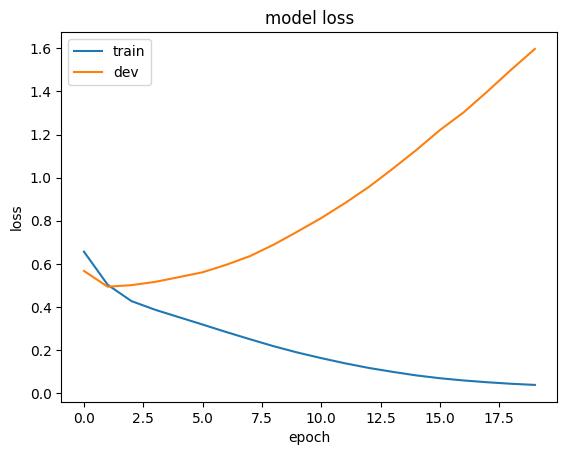

In [ ]:
input_size = x_train[0].shape[0] ## vector length equals to vocabulary size.

# Define the model TODO: add a third intermediate layer
model = Sequential()
model.add(Dense(units=16, activation='relu', input_shape=(input_size,)))
#insert here another layer with 16 neurons (units)
model.add(Dense(units=1, activation='sigmoid'))
# Note that we do not need to indicate the input shape for the sucessives layers

# Compile the model using a loss function and an optimizer.
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

# Train the model
history = model.fit(x_train, y_train, epochs=20, batch_size=32, validation_data=(x_dev, y_dev), verbose=1)
history_orig = history

# summarize history for accuracy
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper left')
plt.show()

## 4. Regularization techniques

We will apply the following ones:
- Reducing the network size
- Adding weight regularization
- Adding dropout

### 4.1 Reducing the network size
One way to prevent overfitting is to reduce the size of the model. As we know the size of the model is measured with the number of parameters that we need to learn. Remenber that the number of parameters are determined by the number of layers and the number of units per layer.



### Exercise 4
Run the following cell of code and try to answer the following question:
- Can you describe the relation of training and validation loss curves when traning with less parameters?

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_7 (Dense)                      │ (None, 4)                   │           4,004 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 4)                   │              20 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │               5 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,029 (15.74 KB)

 Trainable params: 4,029 (15.74 KB)

 Non-trainable params: 0 (0.00 B)

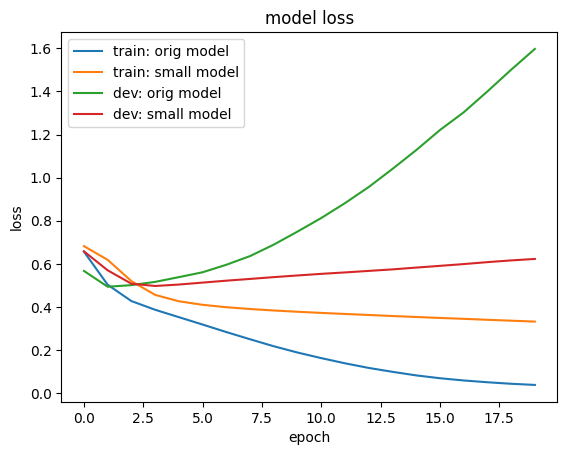

In [ ]:
input_size = x_train[0].shape[0] ## vector length equals to vocabulary size.

# Define the model
model = Sequential()
model.add(Dense(units=4, activation='relu', input_shape=(input_size,)))
model.add(Dense(units=4, activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))
# Note that we do not need to indicate the input shape for the sucessives layes

# Compile the model using a loss function and an optimizer.
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

# Train the model
history = model.fit(x_train, y_train, epochs=20, batch_size=32, validation_data=(x_dev, y_dev), verbose=0)

# summarize history for accuracy
plt.plot(history_orig.history['loss'])
plt.plot(history.history['loss'])

plt.plot(history_orig.history['val_loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train: orig model', 'train: small model', 'dev: orig model', 'dev: small model'], loc='upper left')
plt.show()

We can compare the loss of bigger model with a higher _capacity_. Note that a model with a higher number of parameters has more memorization capacity and consequently can show a poorer generalization with higher risk of overfitting to training data.

### Exercise 5
Run the following cell of code and try to answer the following question:
- Can you describe the relation of training and validation loss curves when traning with more parameters?

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_10 (Dense)                     │ (None, 512)                 │         512,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 775,681 (2.96 MB)

 Trainable params: 775,681 (2.96 MB)

 Non-trainable params: 0 (0.00 B)

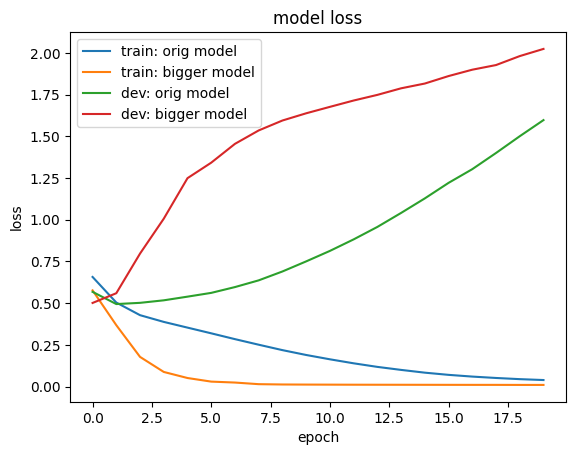

In [ ]:
input_size = x_train[0].shape[0] ## vector length equals to vocabulary size.

# Define the model
model = Sequential()
model.add(Dense(units=512, activation='relu', input_shape=(input_size,)))
model.add(Dense(units=512, activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))
# Note that we do not need to indicate the input shape for the sucessives layes

# Compile the model using a loss function and an optimizer.
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

# Train the model
history = model.fit(x_train, y_train, epochs=20, batch_size=32, validation_data=(x_dev, y_dev), verbose=0)

# summarize history for accuracy
plt.plot(history_orig.history['loss'])
plt.plot(history.history['loss'])

plt.plot(history_orig.history['val_loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train: orig model', 'train: bigger model', 'dev: orig model', 'dev: bigger model'], loc='upper left')
plt.show()

-----

### 4.2 Adding weight regularization

Another common way to try avoiding overfitting is to put constraints on the complexity of a network by forcing its weights to only take small values, which makes the distribution of weight values more "regular". This is called _weight regularization_, and it is done by adding to the loss function of the network a cost associated with having large weights. This cost comes in two flavors:

- __L1 regularization__, where the cost added is proportional to the absolute value of the weights coefficients (i.e. to what is called the "L1 norm" of the weights).

- __L2 regularization__, where the cost added is proportional to the square of the value of the weights coefficients.

In Keras, weight regularization is added by passing weight regularizer instances to layers as keyword arguments. In this case, we'll use the L2 norm to regularize the weights of the model.

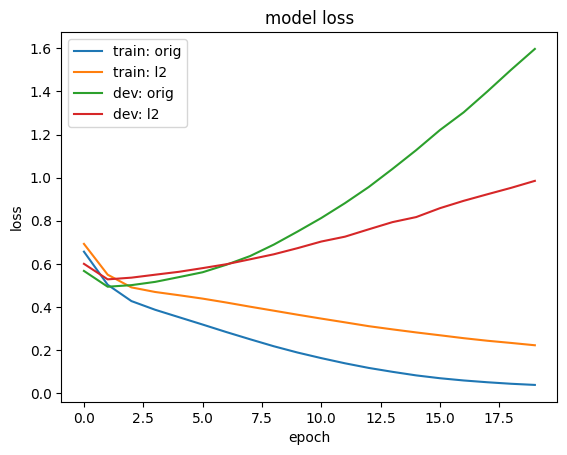

In [ ]:
from tensorflow.keras import regularizers

input_size = x_train[0].shape[0] ## vector length equals to vocabulary size.

# Define the model
model = Sequential()
model.add(Dense(16, kernel_regularizer=regularizers.l2(0.001),
                          activation='relu', input_shape=(input_size,)))
model.add(Dense(16, kernel_regularizer=regularizers.l2(0.001),
                          activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile the model using a loss function and an optimizer.
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
history_l2 = model.fit(x_train, y_train, epochs=20, batch_size=32, validation_data=(x_dev, y_dev), verbose=0)

# summarize history for accuracy
plt.plot(history_orig.history['loss'])
plt.plot(history_l2.history['loss'])

plt.plot(history_orig.history['val_loss'])
plt.plot(history_l2.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train: orig', 'train: l2', 'dev: orig', 'dev: l2'], loc='upper left')
plt.show()

### Exercise 6
- Explore different regularization weigths (e.g. 0.001, 0.01, 0.1). Do you see any difference in the learning curves?
- You can try __L1 regularization__, or both together.

```
# L1 regularization
regularizers.l1(0.001)

# L1 and L2 regularization at the same time
regularizers.l1_l2(l1=0.001, l2=0.001)
```

-----

### 4.3 Adding dropout
Another popular regularization technique for deep learning is _dropout_. It has been proven to be very successful in many cases, which state-of-the-art of the architecture can be improved around 1-2% of accuracy.

The algorithm is simple: At every training step every unit has a probability $p$ of being dropped out (it will not take into account during the evaluation step, setting it to zero).  In Keras user needs to set a _dropout rate_, which is the fraction of the features that are being zeroed-out; it is usually set between 0.2 and 0.5. At test time, no units are dropped out, and instead the layer's output values are scaled down by a factor equal to the dropout rate, so as to balance for the fact that more units are active than at training time.

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 16)                16016     
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_17 (Dense)             (None, 16)                272       
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 17        
Total params: 16,305
Trainable params: 16,305
Non-trainable params: 0
_________________________________________________________________


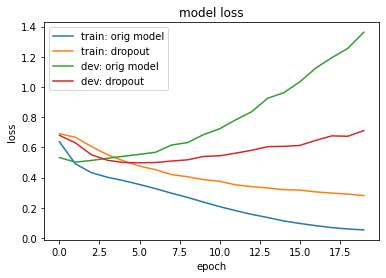

In [ ]:
from tensorflow.keras.layers import Dropout

input_size = x_train[0].shape[0] ## vector length equals to vocabulary size.

# Define the model
model = Sequential()
model.add(Dense(units=16, activation='relu', input_shape=(input_size,)))
# we add a drop-out layer after the first fully connected layer
model.add(Dropout(0.5))

model.add(Dense(units=16, activation='relu'))
# we add a drop-out layer after the second fully connected layer
model.add(Dropout(0.5))
model.add(Dense(units=1, activation='sigmoid'))

# Compile the model using a loss function and an optimizer.
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

# Train the model
history = model.fit(x_train, y_train, epochs=20, batch_size=32, validation_data=(x_dev, y_dev), verbose=0)

# summarize history for accuracy
plt.plot(history_orig.history['loss'])
plt.plot(history.history['loss'])

plt.plot(history_orig.history['val_loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train: orig model', 'train: dropout', 'dev: orig model', 'dev: dropout'], loc='upper left')
plt.show()

### Exercise 7
- Try different dropout rates and decide which one is the best.

## Improve your model
It would be great if you could try improving the model by exploring different hyperparameters. For example,  you can explore the following ones:
- Learning Rates of the optimizer.
- Combination of different regularization techniques.
- Vocabulary size (using larger set of words).
- Number of hidden layers and size of the layers.
- Number of training epochs.
